<a href="https://colab.research.google.com/github/vivekdevulapalli07/TEM_Difp/blob/main/Diffraction_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install mp_api

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.1/217.1 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.6/122.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.1/102.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 69.7 MB/s eta 0:00:00
   ━━━━

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mp_api.client import MPRester
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.analysis.diffraction.tem import TEMCalculator
from pymatgen.core.lattice import Lattice

In [11]:
def get_diffraction_pattern(material_id, zone_axis, api_key=None, voltage=200):
    """
    Retrieves a structure from Materials Project and generates a TEM diffraction pattern
    for a specific zone axis.

    Args:
        material_id (str): The Materials Project ID (e.g., 'mp-149')
        zone_axis (list): The zone axis as a list of three integers [h, k, l]
        api_key (str, optional): Your Materials Project API key. If None, uses environment variable.
        voltage (float, optional): Electron beam energy in keV. Default is 200 keV.

    Returns:
        tuple: (fig, ax) matplotlib figure and axis objects with the diffraction pattern
    """
    # Convert zone axis to tuple of integers
    zone_axis = tuple(map(int, zone_axis))

    # Get the structure from Materials Project
    with MPRester(api_key) as mpr:
        structure = mpr.get_structure_by_material_id(material_id)
        print(f"Retrieved structure: {structure.formula}")

    # Create TEM calculator
    tem_calculator = TEMCalculator(voltage=voltage, beam_direction=zone_axis)

    # Generate the diffraction pattern
    pattern = tem_calculator.get_pattern(structure)

    # Create figure for the diffraction pattern
    fig, ax = plt.subplots(figsize=(10, 10))

    # Extract pattern data from the DataFrame
    pattern_data = pattern.to_dict('records')

    # Scale factor for spot sizes
    intensities = [dot['Intensity (norm)'] for dot in pattern_data]
    max_intensity = max(intensities) if intensities else 1
    scale_factor = 200 / max_intensity

    # Plot the diffraction spots
    for dot in pattern_data:
        # Skip the direct beam for now (it will be added separately)
        hkl = dot['(hkl)']
        if hkl == '(0, 0, 0)':
            continue

        # Extract position
        x, y = dot['Position']
        intensity = dot['Intensity (norm)']

        # Plot the spot
        ax.scatter(x, y, s=intensity*scale_factor, c='black')

        # Label the spots with their Miller indices
        hkl_str = ''.join(filter(str.isdigit, hkl))
        ax.text(x, y+0.05, hkl_str, ha='center', fontsize=8)

    # Add a central spot (direct beam)
    ax.scatter(0, 0, s=200, c='black', marker='o')
    ax.text(0, 0.02, '000', ha='center', fontsize=8)

    # Set plot limits
    max_range = 4  # Default range
    if pattern_data:
        x_coords = [dot['Position'][0] for dot in pattern_data]
        y_coords = [dot['Position'][1] for dot in pattern_data]
        if x_coords and y_coords:
            max_coord = max(max(abs(np.array(x_coords))), max(abs(np.array(y_coords))))
            max_range = max_coord * 1.2

    ax.set_xlim(-max_range, max_range)
    ax.set_ylim(-max_range, max_range)

    # Add labels and title
    ax.set_xlabel('Distance (cm)')
    ax.set_ylabel('Distance (cm)')
    ax.set_title(f'TEM Diffraction Pattern for {structure.formula}\nZone Axis: [{zone_axis[0]} {zone_axis[1]} {zone_axis[2]}]')
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.7)

    return fig, ax, pattern

def get_diffraction_pattern_from_cif(cif_file, zone_axis, voltage=200):
    """
    Generates a TEM diffraction pattern from a local CIF file for a specific zone axis.

    Args:
        cif_file (str): Path to the CIF file
        zone_axis (list): The zone axis as a list of three integers [h, k, l]
        voltage (float, optional): Electron beam energy in keV. Default is 200 keV.

    Returns:
        tuple: (fig, ax) matplotlib figure and axis objects with the diffraction pattern
    """
    from pymatgen.core.structure import Structure

    # Convert zone axis to tuple of integers
    zone_axis = tuple(map(int, zone_axis))

    # Load structure from CIF file
    structure = Structure.from_file(cif_file)
    print(f"Loaded structure from file: {structure.formula}")

    # Create TEM calculator
    tem_calculator = TEMCalculator(voltage=voltage, beam_direction=zone_axis)

    # Generate the diffraction pattern
    pattern = tem_calculator.get_pattern(structure)

    # Create figure for the diffraction pattern
    fig, ax = plt.subplots(figsize=(10, 10))

    # Scale factor for spot sizes
    scale_factor = 50 / max(pattern.intensities) if len(pattern.intensities) > 0 else 50

    # Plot the diffraction spots
    for hkl, intensity, (x, y) in zip(pattern.hkls, pattern.intensities, pattern.coordinates):
        ax.scatter(x, y, s=intensity*scale_factor, c='black')
        # Label the spots with their Miller indices
        hkl_str = ''.join([str(int(i)) for i in hkl])
        ax.text(x, y+0.02, hkl_str, ha='center', fontsize=8)

    # Add a central spot (direct beam)
    ax.scatter(0, 0, s=200, c='black', marker='o')
    ax.text(0, 0.02, '000', ha='center', fontsize=8)

    # Set plot limits to show all spots
    max_range = max([abs(coord).max() for coord in pattern.coordinates]) * 1.2 if pattern.coordinates else 2
    ax.set_xlim(-max_range, max_range)
    ax.set_ylim(-max_range, max_range)

    # Add labels and title
    ax.set_xlabel('Distance (cm)')
    ax.set_ylabel('Distance (cm)')
    cif_name = cif_file.split('/')[-1].split('.')[0]
    ax.set_title(f'TEM Diffraction Pattern for {cif_name}\nZone Axis: [{zone_axis[0]} {zone_axis[1]} {zone_axis[2]}]')
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.7)

    return fig, ax, pattern

def download_and_save_cif(material_id, api_key=None, output_file=None):
    """
    Downloads a CIF file from Materials Project and saves it locally.

    Args:
        material_id (str): The Materials Project ID (e.g., 'mp-149')
        api_key (str, optional): Your Materials Project API key. If None, uses environment variable.
        output_file (str, optional): Path to save the CIF file. If None, uses material_id.cif

    Returns:
        str: Path to the saved CIF file
    """
    if output_file is None:
        output_file = f"{material_id}.cif"

    # Get the structure from Materials Project
    with MPRester(api_key) as mpr:
        structure = mpr.get_structure_by_material_id(material_id)
        print(f"Retrieved structure: {structure.formula}")

        # Save as CIF
        structure.to(filename=output_file)
        print(f"Saved CIF file to: {output_file}")

    return output_file


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved structure: Si2


TypeError: descriptor 'isdigit' for 'str' objects doesn't apply to a 'int' object

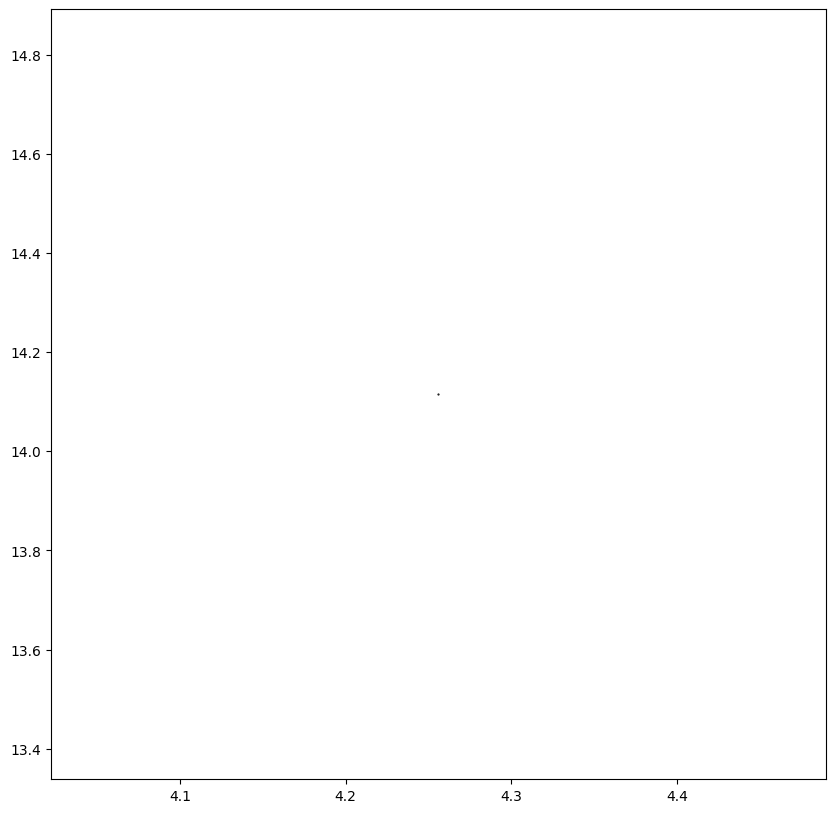

In [12]:
# Example usage
if __name__ == "__main__":
    # Example 1: Get diffraction pattern directly from Materials Project
    material_id = "mp-149"  # Silicon
    zone_axis = [0, 0, 1]   # [001] zone axis
    api_key = "daOUQsZxLXFDwpCXnB0uBMoXiicXZ8nq"  # Replace with your Materials Project API key or set the MP_API_KEY environment variable

    fig, ax, pattern = get_diffraction_pattern(material_id, zone_axis, api_key)
    plt.show()

    # Optionally save the figure
    fig.savefig(f"{material_id}_zone_{zone_axis[0]}{zone_axis[1]}{zone_axis[2]}.png", dpi=300)

    # Example 2: Download CIF file and then generate diffraction pattern
    cif_file = download_and_save_cif(material_id, api_key)
    zone_axis = [1, 1, 0]  # [110] zone axis

    fig2, ax2, pattern2 = get_diffraction_pattern_from_cif(cif_file, zone_axis)
    plt.show()

    # Optionally save the figure
    fig2.savefig(f"{material_id}_zone_{zone_axis[0]}{zone_axis[1]}{zone_axis[2]}_from_cif.png", dpi=300)

    # Example 3: Generate multiple diffraction patterns with different zone axes
    material_id = "mp-81"  # Fe
    api_key = "YOUR_API_KEY_HERE"

    # List of common zone axes to explore
    zone_axes = [[0,0,1], [1,1,0], [1,1,1], [1,0,0]]

    with MPRester(api_key) as mpr:
        structure = mpr.get_structure_by_material_id(material_id)
        print(f"Exploring diffraction patterns for {structure.formula}")

    # Create a figure with subplots for each zone axis
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    axs = axs.flatten()

    for i, zone_axis in enumerate(zone_axes):
        # Create TEM calculator for this zone axis
        tem_calculator = TEMCalculator(voltage=200, beam_direction=tuple(zone_axis))

        # Generate the diffraction pattern
        pattern = tem_calculator.get_pattern(structure)

        # Extract pattern data from the DataFrame
        pattern_data = pattern.to_dict('records')

        # Scale factor for spot sizes
        intensities = [dot['Intensity (norm)'] for dot in pattern_data]
        max_intensity = max(intensities) if intensities else 1
        scale_factor = 100 / max_intensity

        # Plot the diffraction spots
        for dot in pattern_data:
            if dot['(hkl)'] == '(0, 0, 0)':
                continue

            x, y = dot['Position']
            intensity = dot['Intensity (norm)']

            axs[i].scatter(x, y, s=intensity*scale_factor, c='black')

            # Label significant spots
            if intensity > 0.3:
                hkl_str = ''.join(filter(str.isdigit, str(dot['(hkl)'])))
                axs[i].text(x, y+0.05, hkl_str, ha='center', fontsize=8)

        # Add a central spot (direct beam)
        axs[i].scatter(0, 0, s=200, c='black', marker='o')

        # Set plot limits
        axs[i].set_xlim(-4, 4)
        axs[i].set_ylim(-4, 4)

        # Add labels and title
        axs[i].set_title(f'Zone Axis: [{zone_axis[0]} {zone_axis[1]} {zone_axis[2]}]')
        axs[i].set_aspect('equal')
        axs[i].grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.suptitle(f'TEM Diffraction Patterns for {structure.formula}', fontsize=16, y=1.02)
    plt.savefig(f"{material_id}_multiple_zones.png", dpi=300, bbox_inches='tight')